Importacoes, carregamento dos dados, definicao da rede classificadora e treinamento

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch

In [9]:
import numpy as np

In [18]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset_reduzido = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])[0]
# Create data loaders
trainloader = DataLoader(trainset_reduzido, batch_size=256, shuffle=True)

In [33]:
net = Net()
params_init = [param.clone().detach() for param in net.parameters()]
for i, param in enumerate(net.parameters()):
    if i == 9:
        print(f'parametro inicial, camada final: {param[0]}')
grads_acu = [torch.zeros_like(param) for param in net.parameters()]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
net.train()
for epoch in range(2):
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        params_anterior = [param.clone().detach() for param in net.parameters()]
        loss.backward()
        optimizer.step()
        for i, param in enumerate(net.parameters()):
            grads_acu[i] += param.grad
            # if i == 9:
            #     print(f'parametro anterior: {params_anterior[i][0]}')
            #     print(f'gradiente da iteracao: {param.grad[0]}')
            #     print(f'parametro anterior - gradiente: {params_anterior[i][0] - 0.01*param.grad[0]}')
            #     print(f'parametro atualizado: {param[0]}')
gradients = [grad.cpu().numpy() for grad in grads_acu] 
for i, param in enumerate(net.parameters()):
    if i == 9:
        print(f'parametros finais, camada final: {param[0]} gradi total: {gradients[9][0]}')

parametro inicial, camada final: 0.04712291806936264
parametros finais, camada final: 0.046314749866724014 gradi total: 0.08081717044115067


Teste para qualidade visual das imagens geradas pelo modelo generativo

In [28]:
import torch
from torch import nn
import numpy as np
from collections import OrderedDict

In [2]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100, batch_size=64):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.latent_dim + self.classes, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, input, labels):
        if input.dim() == 2:
            z = torch.cat((self.label_embedding(labels), input), -1)
            x = self.generator(z)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x
        elif input.dim() == 4:
            x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)


def train(net, trainloader, epochs, learning_rate, device, dataset="mnist", latent_dim=100):
    """Train the network on the training set."""
    if dataset == "mnist":
      imagem = "image"
    elif dataset == "cifar10":
      imagem = "img"

    net.to(device)  # move model to GPU if available
    optim_G = torch.optim.Adam(net.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optim_D = torch.optim.Adam(net.discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    g_losses = []
    d_losses = []


    for epoch in range(epochs):
        for batch_idx, batch in enumerate(trainloader):
            images, labels = batch[imagem].to(device), batch["label"].to(device)
            batch_size = images.size(0)
            real_ident = torch.full((batch_size, 1), 1., device=device)
            fake_ident = torch.full((batch_size, 1), 0., device=device)

            # Train G
            net.zero_grad()
            z_noise = torch.randn(batch_size, latent_dim, device=device)
            x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
            x_fake = net(z_noise, x_fake_labels)
            y_fake_g = net(x_fake, x_fake_labels)
            g_loss = net.loss(y_fake_g, real_ident)
            g_loss.backward()
            optim_G.step()

            # Train D
            net.zero_grad()
            y_real = net(images, labels)
            d_real_loss = net.loss(y_real, real_ident)
            y_fake_d = net(x_fake.detach(), x_fake_labels)
            d_fake_loss = net.loss(y_fake_d, fake_ident)
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optim_D.step()

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            if batch_idx % 100 == 0 and batch_idx > 0:
                print('Epoch {} [{}/{}] loss_D_treino: {:.4f} loss_G_treino: {:.4f}'.format(
                            epoch, batch_idx, len(trainloader),
                            d_loss.mean().item(),
                            g_loss.mean().item()))



def test(net, testloader, device, dataset="mnist", latent_dim=100):
    """Validate the network on the entire test set."""
    if dataset == "mnist":
      imagem = "image"
    elif dataset == "cifar10":
      imagem = "img"
    g_losses = []
    d_losses = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(testloader):
            images, labels = batch[imagem].to(device), batch["label"].to(device)
            batch_size = images.size(0)
            real_ident = torch.full((batch_size, 1), 1., device=device)
            fake_ident = torch.full((batch_size, 1), 0., device=device)

            #Gen loss
            z_noise = torch.randn(batch_size, latent_dim, device=device)
            x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
            x_fake = net(z_noise, x_fake_labels)
            y_fake_g = net(x_fake, x_fake_labels)
            g_loss = net.loss(y_fake_g, real_ident)

            #Disc loss
            y_real = net(images, labels)
            d_real_loss = net.loss(y_real, real_ident)
            y_fake_d = net(x_fake.detach(), x_fake_labels)
            d_fake_loss = net.loss(y_fake_d, fake_ident)
            d_loss = (d_real_loss + d_fake_loss) / 2

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            if batch_idx % 100 == 0 and batch_idx > 0:
                print('[{}/{}] loss_D_teste: {:.4f} loss_G_teste: {:.4f}'.format(
                            batch_idx, len(testloader),
                            d_loss.mean().item(),
                            g_loss.mean().item()))
    return np.mean(g_losses), np.mean(d_losses)


def get_weights(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [3]:
import matplotlib.pyplot as plt
#import random

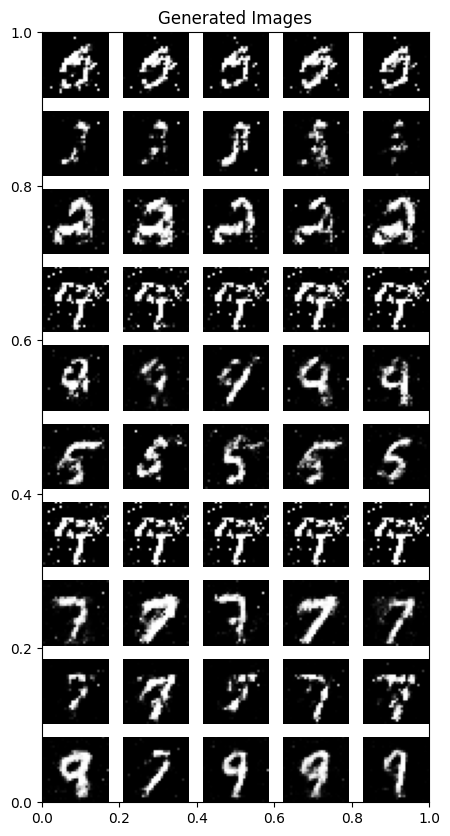

In [7]:
seed = 42
latent_dim = 100
# random.seed(seed)
# np.random.seed(seed)
#torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = "cpu"
net = CGAN(dataset="mnist", latent_dim=latent_dim).to(device)
net.load_state_dict(torch.load('modelo_gen_round_13_client_1.pt'))

# Set the model to evaluation mode
net.eval()
# Assuming netG is your generator model, classes is the total number of classes, and latent_dim is the latent vector size
examples_per_class = 5
classes = 10
batch_size = examples_per_class * classes  # Generate enough images to have `examples_per_class` for each class

# Generate latent vectors and corresponding labels
latent_vectors = torch.randn(batch_size, latent_dim, device=device)
labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)

# Generate images
with torch.no_grad():
    generated_images = net(latent_vectors, labels)

fig = plt.figure(figsize=(examples_per_class, classes))
plt.title("Generated Images")
for i in range(generated_images.shape[0]):
    plt.subplot(10, 5, i+1)
    plt.imshow(generated_images[i, 0, :, :], cmap='gray')
    plt.axis('off')
    plt.savefig("mnist_CGAN_20r_2e_64b_100z_10c_28i_0001lr_niid_01dir.png")

In [3]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

In [97]:
partitioner = IidPartitioner(num_partitions=1)
dataset = FederatedDataset(dataset="scikit-learn/adult-census-income", partitioners={"train": partitioner})

In [1]:
import pandas as pd

In [2]:
# Column names for the dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

# Load the Adult dataset
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

# Load training data
train_data = pd.read_csv(train_url, header=None, names=columns, na_values=[" ?"], skipinitialspace=True)

# Load test data
test_data = pd.read_csv(test_url, header=None, names=columns, na_values=[" ?"], skipinitialspace=True, skiprows=1)
test_data["income"] = test_data["income"].str.strip(".")  # Clean income column in test set

# Remove the 'fnlwgt' column
# train_data = train_data.drop(columns=['fnlwgt', 'education-num'])
# test_data = test_data.drop(columns=['fnlwgt', 'education-num'])

train_data = train_data[train_data['capital-gain'] != 99999]
test_data = test_data[test_data['capital-gain'] != 99999]

# Combine train and test data for consistent preprocessing
data = pd.concat([train_data, test_data], axis=0, ignore_index=True) #adicione e remova train_data e syndata para treinar ou nao com dados reais e sinteticos

# Combinar categorias da variável 'native-country'
data['native-country'] = data['native-country'].replace({
    country: 'Other' for country in data['native-country'].unique() if country != 'United-States'
})

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

KeyboardInterrupt: 

In [15]:
# Column names for the dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education.num",
    "marital.status", "occupation", "relationship", "race", "sex",
    "capital.gain", "capital.loss", "hours.per.week", "native.country", "income"
]

# Load the Adult dataset
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

# Load training data
train_data = pd.read_csv(train_url, header=None, names=columns, na_values=[" ?"], skipinitialspace=True)

In [6]:
from flwr_datasets.partitioner import IidPartitioner
from flwr_datasets import FederatedDataset

In [106]:
partitioner = IidPartitioner(num_partitions=1)
fds_data = FederatedDataset(dataset="scikit-learn/adult-census-income", partitioners={"train": partitioner})
fds_partition = fds_data.load_partition(0, "train")

In [91]:
partitioner = IidPartitioner(num_partitions=1)
xgb_fds_data = FederatedDataset(dataset="jxie/higgs", partitioners={"train": partitioner})
xgb_partition = xgb_fds_data.load_partition(0, "train")
xgb_partition.set_format("numpy")

/Users/Mara/miniconda3/envs/GeraFed/lib/python3.10/site-packages/flwr_datasets/utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/fed-isic2019']. Given: jxie/higgs.
  warnings.warn(


In [92]:
xgb_data = xgb_partition.train_test_split(0.95)
xgb_data_train = xgb_data["train"]

In [93]:
len(xgb_data_train)

525000

In [108]:
fds_data = fds_partition.train_test_split(0.2)
fds_data_train = fds_data["train"]

In [109]:
len(fds_data_train)

26048

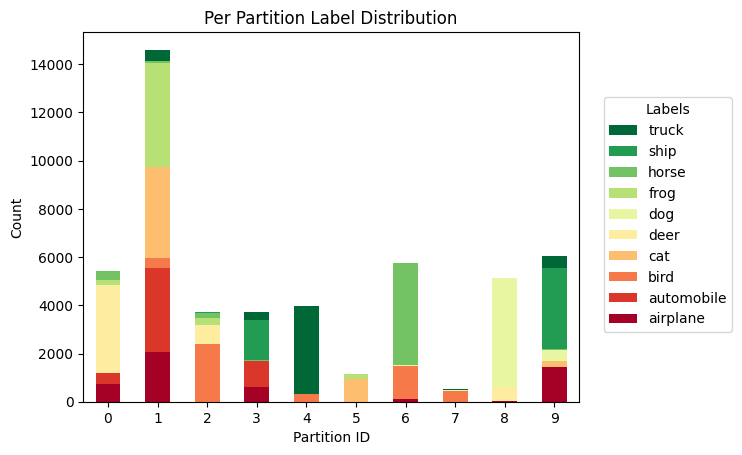

In [123]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions

partitioner = DirichletPartitioner(
	num_partitions = 10,
	partition_by = "label",
	alpha = 0.1,
	min_partition_size = 0,
	self_balancing = False
)
fds = FederatedDataset(
    dataset="cifar10",
    partitioners={
        "train": partitioner,
    },
    trust_remote_code=True,
)
partitioner = fds.partitioners["train"]
figure, axis, dataframe = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    title="Per Partition Label Distribution",
    legend=True,
    verbose_labels=True,
    size_unit="absolute",
    partition_id_axis="x",
)

In [126]:
total = 0
for i in range(10):
    print(len(fds.load_partition(i, "train")))
    total += len(fds.load_partition(i, "train"))

5433
total: 5433
14604
total: 20037
3708
total: 23745
3722
total: 27467
3958
total: 31425
1143
total: 32568
5742
total: 38310
526
total: 38836
5120
total: 43956
6044
total: 50000


In [125]:
total/10

5000.0

In [96]:
xgb_X = xgb_data_train["inputs"]
xgb_y = xgb_data_train["label"]

In [69]:
import xgboost as xgb

In [97]:
new_data = xgb.DMatrix(xgb_X, label=xgb_y)

In [98]:
new_data

In [72]:
from sklearn.preprocessing import LabelEncoder

In [111]:
fds_df = fds_data_train.to_pandas()

In [112]:
categorical_columns = fds_df.select_dtypes(include=["object"]).columns

# Aplicar Label Encoding às colunas categóricas
for col in categorical_columns:
    le = LabelEncoder()
    fds_df[col] = le.fit_transform(fds_df[col])

In [113]:
fds_X2 = fds_df.drop(columns=["income"]).values
fds_y2 = fds_df["income"].values

In [114]:
new_data_adult = xgb.DMatrix(fds_X2, label=fds_y2)

In [115]:
new_data_adult

In [35]:
xgb_data_train

Dataset({
    features: ['inputs', 'label'],
    num_rows: 8400000
})

In [36]:
xgb_data2_train

Dataset({
    features: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income'],
    num_rows: 26048
})

In [98]:
dataset = dataset.load_partition(0, "train").with_format("pandas")[:]

In [104]:
dataset.replace('?', np.nan, inplace=True)

In [107]:
dataset.dropna(inplace=True)

In [ ]:
dataset

In [176]:
train_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6.0,77516,9.0,13,4.0,0.0,1.0,4.0,1.0,2174,0,40,38.0,0.0
1,50,5.0,83311,9.0,13,2.0,3.0,0.0,4.0,1.0,0,0,13,38.0,0.0
2,38,3.0,215646,11.0,9,0.0,5.0,1.0,4.0,1.0,0,0,40,38.0,0.0
3,53,3.0,234721,1.0,7,2.0,5.0,0.0,2.0,1.0,0,0,40,38.0,0.0
4,28,3.0,338409,9.0,13,2.0,9.0,5.0,2.0,0.0,0,0,40,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,3.0,257302,7.0,12,2.0,12.0,5.0,4.0,0.0,0,0,38,38.0,0.0
32557,40,3.0,154374,11.0,9,2.0,6.0,0.0,4.0,1.0,0,0,40,38.0,1.0
32558,58,3.0,151910,11.0,9,6.0,0.0,4.0,4.0,0.0,0,0,40,38.0,0.0
32559,22,3.0,201490,11.0,9,4.0,0.0,3.0,4.0,1.0,0,0,20,38.0,0.0


In [96]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

In [161]:
categorical_cols = dataset.select_dtypes(include=["object"]).columns
ordinal_encoder = OrdinalEncoder()
dataset[categorical_cols] = ordinal_encoder.fit_transform(dataset[categorical_cols])

X = dataset.drop("income", axis=1)
y = dataset["income"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
    )

In [185]:
categorical_cols = train_data.select_dtypes(include=["object"]).columns
ordinal_encoder = OrdinalEncoder()
train_data[categorical_cols] = ordinal_encoder.fit_transform(train_data[categorical_cols])

X = train_data.drop("income", axis=1)
y = train_data["income"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
    )

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset
import torch

In [186]:
numeric_features = X_train.select_dtypes(include=["float64", "int64"]).columns
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [173]:
class IncomeClassifier(nn.Module):
    def __init__(self, input_dim: int = 14):
        super(IncomeClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

In [64]:
import torch.optim as optim

In [187]:
model = IncomeClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(5):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

In [188]:
model.eval()
criterion = nn.BCELoss()
loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        batch_loss = criterion(outputs, y_batch)
        loss += batch_loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
accuracy = correct / total
loss = loss / len(test_loader)

In [189]:
accuracy

0.8493781667434362